# 참고한 URL
###### - 토픽모델링: https://happy-obok.tistory.com/5
###### - 한글 형태소패키지 설치: https://todaycodeplus.tistory.com/m/43
###### - JDK1.8 설치: https://todaycodeplus.tistory.com/42?category=988489
###### - 윈도우 환경에서 konlpy 설치: https://ingu627.github.io/tips/install_konlpy/
###### - Colab에서 konlpy와 mecab 설치: https://sanghyu.tistory.com/170
###### - Colab에서 Mallet 활용: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 뉴스 기사 웹크롤링

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse

In [ ]:
# KODEX 이차전지 ETF 종목 주가 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/Kodex_2ndBattery_20180912_20220719(결측치 채움).csv', encoding='utf-8-sig')
df = df[df.일자>='2018/01/01']
df = df.reset_index(drop=True)
df = df[['일자','종가','시가','고가','저가']]

df

,일자,종가,시가,고가,저가
0,2019-01-01,8650.0,8715.0,8760.0,8570.0
1,2019-01-02,8340.0,8725.0,8755.0,8310.0
2,2019-01-03,8140.0,8345.0,8375.0,8130.0
3,2019-01-04,8180.0,8080.0,8180.0,7985.0
4,2019-01-05,8180.0,8080.0,8180.0,7985.0
...,...,...,...,...,...
1289,2022-07-13,17155.0,16675.0,17165.0,16515.0
1290,2022-07-14,17445.0,17445.0,17700.0,17340.0
1291,2022-07-15,17350.0,17470.0,17530.0,17165.0
1292,2022-07-16,17350.0,17470.0,17530.0,17165.0


In [ ]:
Dates = []
for i in range(0, len(df)):
    Dates.append(str(df['일자'].tolist()[i])[:10].replace('-',''))
Dates[:5]

['20190101', '20190102', '20190103', '20190104', '20190105']

In [ ]:
result_list = []
add_date = []
error_cnt = 0

def paxnet_news_title(dates):
    base_url = 'http://www.paxnet.co.kr/news/much?newsSetId=4667&currentPageNo={}&genDate={}&objId=N4667'
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'
    }
    
    for date in dates:
        for page in range(1, 3):
            url = base_url.format(page, date)
            res = requests.get(url, headers=headers)
            if res.status_code == 200:
                soup = BeautifulSoup(res.text)
                title_list = soup.select('ul.thumb-list li')
                for title in title_list:
                    try:
                        news_title = title.select_one('dl.text > dt').text.strip()
                        result_list.append([news_title])
                        add_date.append(date)
                    except:
                        error_cnt += 1

In [ ]:
paxnet_news_title(Dates)
title_df = pd.DataFrame({'일자':add_date,'뉴스제목':result_list})

In [ ]:
title_df.일자 = pd.to_datetime(title_df.일자, format='%Y-%m-%d')
title_df.sort_values(by='일자', inplace=True)
title_df.reset_index(drop=True, inplace=True)
# title_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/팍스넷_뉴스타이틀_20190101_20220717(이차전지)(날짜추가).csv', index=False, encoding='utf-8')

# 2. 수집한 뉴스 데이터 전처리

### 2-1. 필요한 칼럼 불러오기

In [ ]:
import pandas as pd
from datetime import datetime

# 팍스넷 뉴스타이틀 불러오기
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/팍스넷_뉴스타이틀_20190101_20220717(이차전지)(날짜추가).csv', encoding='utf-8-sig')
# data['date'] = pd.to_datetime(data.date)
# data = data.sort_values(by='date')
# data = data.reset_index()
data = data[['일자','뉴스제목']]
data

,일자,뉴스제목
0,2019-01-01,"[""폭락장에도 급등한 주식 이유있네…'실적 개선·사업다각화'""]"
1,2019-01-01,['작년 무역 사상 최대 1조1405억弗']
2,2019-01-01,['74개 車모델 자차보험료 오른다']
3,2019-01-01,"['[J턴의 조건] 규제, 규제, 규제… 무주택자 숨통까지 죈 대출규제 손봐야']"
4,2019-01-01,"['2018년 美 증시, 글로벌 금융위기 이후 최악의 성적으로 마감']"
...,...,...
54996,2022-07-17,"[""[펀드와치]K팝스타 컴백에 우영우 인기몰이…미디어 펀드 '훨훨'""]"
54997,2022-07-17,['中휴가철 코로나 재확산에 예약 취소 속출']
54998,2022-07-17,"[""중견 회계법인 '감사 갑질' 막는다…금융위, 지정감사제 '손질'""]"
54999,2022-07-17,['[포토]한풀 꺾인 국제유가·정제마진…국내 기름값 진정세']


### 2-2. 텍스트 전처리(1)

In [ ]:
import numpy as np

# 데이터 프레임의 'content' 열의 값들을 str 형식으로 바꾸기
data.뉴스제목 = data.뉴스제목.astype(str)

#데이터 프레임의 'text' 열의 값 중 keyword1이나 keyword 2가 포함된 행만 Data에 저장
#clean_Data = Data.loc[Data['text'].str.contains('keyword1|keyword2')]

#데이터 프레임의 'text' 열의 값 중 keyword1이나 keyword 2가 포함된 행은 삭제
#clean_Data = Data[~Data['text'].str.contains('keyword1|keyword2')]

#text와 timestamp 열을 기준으로 중복된 데이터를 삭제, inplace : 데이터 프레임을
#변경할지 선택(원본을 대체)
data.drop_duplicates(subset=['뉴스제목'], inplace=True)

# 한글이 아니면 빈 문자열로 바꾸기
data['뉴스제목'] = data['뉴스제목'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','',regex=True)

# 빈 문자열 NAN 값으로 바꾸기???
clean_data = data.replace({'':np.nan})
clean_data = data.replace(r'^\s*$', None, regex=True)

#NAN 이 있는 행은 삭제
clean_data.dropna(how='any', inplace=True)

#인덱스 차곡차곡
clean_data = clean_data.reset_index(drop=True)

import re

# Remove Punctuation
# clean_data['title'] = clean_data['title'].map(lambda x: re.sub('[,\.!?]', '', x))
clean_data['뉴스제목'] = clean_data['뉴스제목'].map(lambda x: re.sub('[,\.!?]', '', x))


# 데이터 프레임에 null 값이 있는지 확인
print(clean_data.isnull().values.any())
print(clean_data.shape)

False
(25608, 2)


### 2-3. 텍스트 전처리(2)

In [ ]:
def clean_text(inputString):
    text_rmv = re.sub('[+]','증가', inputString)
    text_rmv = re.sub('[-]','감소', text_rmv)
    text_rmv = re.sub('[↑]','상승', text_rmv)
    text_rmv = re.sub('[↓]','하락', text_rmv)
    text_rmv = re.sub(r'\d+',' ', text_rmv)
    # text_rmv = text_rmv.replace('\n', '')
    text_rmv = re.sub('[^一-龥ㄱ-힣a-zA-Z0-9_]', ' ', text_rmv)
    return text_rmv

for i in range(clean_data.shape[0]):
    clean_data.iloc[i,1] = clean_text(clean_data.iloc[i,1])
clean_data

,일자,뉴스제목
0,2019-01-01,폭락장에도급등한주식이유있네실적개선사업다각화
1,2019-01-01,작년무역사상최대조억
2,2019-01-01,개모델자차보험료오른다
3,2019-01-01,턴의조건규제규제규제무주택자숨통까지죈대출규제손봐야
4,2019-01-01,년증시글로벌금융위기이후최악의성적으로마감
...,...,...
25603,2022-07-17,펀드와치팝스타컴백에우영우인기몰이미디어펀드훨훨
25604,2022-07-17,휴가철코로나재확산에예약취소속출
25605,2022-07-17,중견회계법인감사갑질막는다금융위지정감사제손질
25606,2022-07-17,포토한풀꺾인국제유가정제마진국내기름값진정세


# 3. 뉴스 데이터로 한국어 형태소 분석기 진행

### 3-1. 필요한 패키지 설치하기

In [ ]:
# bash 셸로 명렁어를 입력하여 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

# 환경변수 설정
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

# mecab 설치(시간 꽤 소요됨)
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [817 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

bash: line 7: fg: no job control
bash: line 10: fg: no job control
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   957k      0  0:00:01  0:00:01 --:--:-- 2268k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Sourc

In [ ]:
# 패키지 불러오기
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

### 3-2. 텍스트 데이터 중 명사만 따로 모으기

In [ ]:
#텍스트 데이터를 리스트로 변환
Data_list=clean_data.뉴스제목.values.tolist()

okt = Okt()

#리스트를 요소별로(트윗 하나) 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
for i in range(len(Data_list)):
    try:
        data_word.append(okt.nouns(Data_list[i]))
    except Exception as e:
        continue

#트윗에서 명사만 추출해서 만든 리스트
data_word

[['폭락', '급등', '주식', '이유', '실적', '개선', '사업', '다각'],
 ['작년', '무역사', '최대', '조억'],
 ['개', '모델', '차', '보험료'],
 ['턴', '조건', '규제', '규제', '규제', '무', '주택', '숨통', '죈', '대출', '규제', '손'],
 ['년', '증시', '글로벌', '금융위기', '이후', '최악', '성적', '마감'],
 ['기해년', '눈', '볼', '유망', '스몰', '캡'],
 ['년', '기해년', '성장', '이슈', '테마', '발굴', '필요'],
 ['유럽', '증시', '무역', '협상', '기대', '마지막', '거래', '일'],
 ['유럽', '증시', '파리', '런던', '고혼', '마감'],
 ['넷마블', '한화', '에어', '로턴', '라운드', '주목'],
 ['글로벌', '불확실', '기업', '실적', '둔화', '저하', '고장', '세', '전망', '우세'],
 ['한국', '증시', '비관', '계해'],
 ['증권사',
  '리서치',
  '센터',
  '올해',
  '키',
  '워드',
  '박스',
  '피터',
  '닝',
  '포인트',
  '젠틀',
  '마켓',
  '올해',
  '증시'],
 ['설문조사', '수도', '권집', '값', '동결', '폭', '하락'],
 ['뉴욕증시', '강세', '마감', '만년', '최악', '하락'],
 ['새해', '증시', '핫키', '워드', '젠틀', '마켓', '리바운드', '박스'],
 ['증권', '중국', '미국', '하강', '국면', '증시', '모멘텀'],
 ['신흥', '국채', '매도', '금리', '상승', '위험', '자산', '회피', '차원'],
 ['새해', '황금돼지', '종목', '통신', '게임', '엔터테인먼트'],
 ['긴장', '증시', '코스피', '년', '회'],
 ['신화', '김성락', '김연', '추', '새해', '미

In [ ]:
len(data_word)

25608

### 3-3. 한국어 불용어 처리

In [ ]:
# 뉴스타이틀마다 명사로 나눈 데이터(리스트) 불용어 처리

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = ['\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
              '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
              '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
              '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
              '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
             '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
             '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
             '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
             '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
             '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
             '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
             "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최','강세','급등','소식',\
              '표','만원','티','공개','부각','이상','게임','이틀','연속','팔자','오늘','협','하루','주의','관심','주목','년','최고',\
              '스몰','캡','혜주','상승','하락','출발','혼','증','론','마','분기','올해','내년','닝','시즌','작년','급락','후주',\
              '종합','대감','재송','마켓','포인트','위','성전','관순','다시','에스','신규','다음주','워치','헬','돈','스케','케이',\
              ]


result = []

for w in range(len(data_word)):
    sub_result = []
    for ww in data_word[w]:
        if ww not in stop_words:
            sub_result.append(ww)
    result.append(sub_result)

# print(data_word[:10])
# print(result[:10])

In [ ]:
len(result)

25608

In [ ]:
# 사라진 불용어 개수

del_num=0

for i in range(10000):
    del_num += (len(data_word[i]) - len(result[i]))
del_num

17238

### 3-4.pickle 파일로 따로 저장하고 불러오기

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/팍스핏+이차전지.txt', 'wb') as f:
    pickle.dump(result, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/팍스핏+이차전지.txt', 'rb') as f:
    pickle_data = pickle.load(f)

pickle_data

[['폭락', '주식', '실적', '개선', '사업', '다각'],
 ['무역사', '최대', '조억'],
 ['모델', '보험료'],
 ['턴', '조건', '규제', '규제', '규제', '무', '주택', '숨통', '죈', '대출', '규제'],
 ['글로벌', '금융위기', '이후', '최악', '성적'],
 ['기해년', '볼', '유망'],
 ['기해년', '성장', '테마', '발굴', '필요'],
 ['유럽', '무역', '협상', '기대', '마지막', '거래'],
 ['유럽', '파리', '런던', '고혼'],
 ['넷마블', '한화', '에어', '로턴', '라운드'],
 ['글로벌', '불확실', '기업', '실적', '둔화', '저하', '고장', '우세'],
 ['한국', '비관', '계해'],
 ['증권사', '리서치', '센터', '키', '워드', '박스', '피터', '젠틀'],
 ['설문조사', '수도', '권집', '값', '동결'],
 ['뉴욕증시', '만년', '최악'],
 ['새해', '핫키', '워드', '젠틀', '리바운드', '박스'],
 ['증권', '중국', '미국', '하강', '국면', '모멘텀'],
 ['신흥', '국채', '매도', '금리', '위험', '자산', '회피', '차원'],
 ['새해', '황금돼지', '통신', '엔터테인먼트'],
 ['긴장'],
 ['신화', '김성락', '김연', '추', '새해', '미래에셋', '대우', '출근', '트레이딩'],
 ['금융투자', '업계', '돼지', '방', '포부'],
 ['최초', '폴', '더블', '폰', '플렉스', '파이', '중국', '밖', '간다'],
 ['원리금', '이자', '상환', '공제', '서류'],
 ['청와대', '청원', '간주', '새해', '공매도', '좀', '폐'],
 ['스냅', '타임', '슬릭', '매일', '끙끙', '피트', '니트', '센터'],
 ['국제', '및금', '시세'],
 ['화물차

# 4. LDA토픽모델링

### 4-1. 필요한 패키지 설치하기

# Installing Gensim (version=3.8.3)

In [ ]:
# !pip install gensim         # 신버전(사용중)
# !pip uninstall gensim==4.1.2
!pip install gensim==3.8.3  # 구버전(코랩에서 설치가능)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Install Java

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode)


# Install Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-07-22 13:04:13--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-07-22 13:04:14--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.7MB/s    in 0.9s    

2022-07-22 13:04:15 (16.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4-2. LDA 모델에 들어갈 객체 만들기

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
# Colab에 맞게 새로 지정된 mallet_path
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

In [ ]:
data_word = pickle_data

In [ ]:
# LDA 모델에 들어갈 객체 만들기
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

id2word = corpora.Dictionary(data_word)
id2word.filter_extremes(no_below = 10)  # 20회 이하로 등장한 단어 삭제(20->10 변경)
texts = data_word
corpus = [id2word.doc2bow(text) for text in texts]

# mallet_path = '/content/drive/MyDrive/Colab Notebooks/Selenium/Data_NaverNews/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus,
                                            num_topics=10, id2word=id2word)
# gensim.models의 wrappers는 gensim 4.0 버전에서 사라졌으므로,
# 구버전인 3.8.3.을 이용하란 조언이 많았음

### 4-3. Coherence 점수를 계산하여 좋은 LDA 모델 찾기

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts,
                                           dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_word, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=11, step=2)

limit=11; start=4; step=2;
x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1

        
# Select the model and print the topics
optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)
#print(optimal_model.print_topics(num_words=10))



Num Topics = 4  has Coherence Value of 0.32560669202193815
Num Topics = 6  has Coherence Value of 0.37265339072312004
Num Topics = 8  has Coherence Value of 0.36901416780064233
Num Topics = 10  has Coherence Value of 0.37939481041658313


### 4-4. LDA토픽모델링으로 토픽 추출하기

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output -> 본래 기사제목을 넣음
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, data['뉴스제목']], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model,
                                                  corpus=corpus,
                                                  texts=Data_list)  # 일단 낮게 잡음

# Format
df_topic_tweet = df_topic_sents_keywords.reset_index()
df_topic_tweet.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', '뉴스제목']

# Show각 문서에 대한 토픽
#df_dominant_topic=df_dominant_topic.sort_values(by=['Dominant_Topic'])
#df_topic_tweet








# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'],ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
lda_inform.columns=["Topic_Num", "Topic_Perc_Contrib", "Keywords", "뉴스제목","Num_Documents", "Perc_Documents"]
lda_inform = lda_inform[["Topic_Num","Keywords","Num_Documents","Perc_Documents"]]
lda_inform
#lda_inform.Topic_Num = lda_inform.Topic_Num.astype(int)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'] +1
lda_inform.Topic_Num = lda_inform.Topic_Num.astype(str)
lda_inform['Topic_Num'] =lda_inform['Topic_Num'].str.split('.').str[0]
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'] +1
df_topic_tweet.Dominant_Topic = df_topic_tweet.Dominant_Topic.astype(str)
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'].str.split('.').str[0]

<class 'pandas.core.frame.DataFrame'>


In [ ]:
lda_inform.to_csv ("/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/lda_팍스넷+이차전지.csv", index = None)
lda_inform

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0.0,1,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",4071,0.1590
1.0,2,"실적, 기업, 주가, 발표, 영업, 개선, 목표, 이익, 일정, 증가",2987,0.1166
2.0,3,"증권, 한국, 성장, 해외, 영향, 자산, 효과, 랠리, 국내, 자금",2683,0.1048
3.0,4,"금리, 시장, 글로벌, 확대, 트럼프, 채권, 지속, 가능성, 인상, 은행",2649,0.1034
4.0,5,"바이오, 상장, 카카오, 사업, 치료, 셀트리온, 개발, 전략, 거래소, 애플",2543,0.0993
5.0,6,"투자, 펀드, 전자, 금융, 배당, 뉴스, 수혜, 수익률, 일장, 수익",2322,0.0907
6.0,7,"주식, 개미, 반도체, 미국, 중국, 최대, 테슬라, 공매도, 증권사, 수출",2107,0.0823
7.0,8,"코로나, 우려, 유럽, 유가, 확산, 일제, 공포, 국제, 테크, 폭락",2142,0.0836
8.0,9,"뉴욕증시, 무역, 기대, 간증, 협상, 다우, 나스닥, 뉴욕, 지표, 보합",2154,0.0841
9.0,10,"상승세, 달러, 거래, 반등, 돌파, 비트코인, 환율, 테마주, 재테크, 외국",1950,0.0761


### 4-5. 토픽별로 문서 정리하기

In [ ]:
#토픽별 트윗 저장
for i in range(1,topic_num+1):
    globals()['df_{}'.format(i)]=df_topic_tweet.loc[df_topic_tweet.Dominant_Topic==str(i)]
    globals()['df_{}'.format(i)].sort_values('Topic_Perc_Contrib',ascending=False,inplace = True)
    globals()['df_{}'.format(i)].to_csv ("/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/topic("+str(i)+")_tweet.csv",
                                         index = None)

df_1

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,뉴스제목
2430,2430,1,0.2105,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
1609,1609,1,0.2105,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
2656,2656,1,0.2105,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
687,687,1,0.2105,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
1070,1070,1,0.2105,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
...,...,...,...,...,...
6237,6237,1,0.1000,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",뉴질랜드이슬람사원총격테러현장용감한시민화제
16851,16851,1,0.1000,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN
6196,6196,1,0.1000,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",코스닥정상회담지연우려에대하락
6138,6138,1,0.1000,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN


### 4-6. pyLDAvis로 시각화하기

In [ ]:
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=df8ff25b8b13b4face8365d100ee00b9c6e609188c36ee4009d7362240ff105a
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
from gensim.models import LdaModel


def mallet_to_lda(optimal_model):
    model_gensim = LdaModel(
        id2word=optimal_model.id2word, num_topics=optimal_model.num_topics,
        alpha=optimal_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = optimal_model.wordtopics
    return model_gensim
model = mallet_to_lda(optimal_model)

import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
# vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=            x       y  topics  cluster     Freq
topic                                          
6     -0.1088  0.1426       1        1  10.0095
8      0.0605 -0.0270       2        1  10.0064
2     -0.1392  0.0631       3        1  10.0062
7      0.2995 -0.0524       4        1  10.0010
0      0.2095  0.0918       5        1   9.9999
9      0.1395  0.0162       6        1   9.9984
4     -0.0648 -0.2779       7        1   9.9971
1     -0.1302  0.2599       8        1   9.9961
3     -0.1065  0.0276       9        1   9.9950
5     -0.1595 -0.2439      10        1   9.9905, topic_info=      Term       Freq      Total Category  logprob  loglift
2185   코로나  1240.0000  1240.0000  Default  30.0000  30.0000
3       실적  1239.0000  1239.0000  Default  29.0000  29.0000
50    뉴욕증시  1184.0000  1184.0000  Default  28.0000  28.0000
203     투자  1009.0000  1009.0000  Default  27.0000  27.0000
148    외국인   943.0000   943.0000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
1041    미래    60.0444    61.0723  Topic10  -5.1548   2.2866
1488    공모    63.0466    65.0129  Topic10  -5.1060   2.2728
1309    연말    91.0673   104.1344  Topic10  -4.7383   2.1695
153     국내   151.1118   328.9430  Topic10  -4.2319   1.5257
1068    유지    67.0496    94.4560  Topic10  -5.0445   1.9608

[656 rows x 6 columns], token_table=      Topic    Freq Term
term                    
595       6  0.9975   가격
459       9  1.0000  가능성
1370      6  0.9970   가상
1233      4  1.0076   가시
814       5  0.9958   가장
...     ...     ...  ...
675       1  0.0226   흑자
675       3  0.0451   흑자
675       5  0.9362   흑자
712       8  1.0026   희비
633       7  1.0008    힘

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 3, 8, 1, 10, 5, 2, 4, 6])

# 5. 일별 토픽트렌드 비중 수치화

### 5-1. 토픽별 문서 데이터 불러오기

In [ ]:
df_1_date = pd.merge(df_1,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)
df_2_date = pd.merge(df_2,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)
df_3_date = pd.merge(df_3,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)
df_4_date = pd.merge(df_4,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)
df_5_date = pd.merge(df_5,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)
df_6_date = pd.merge(df_6,clean_data.일자, how='left', left_on='Document_No', right_on=clean_data.index)

df_1_date.sort_values(by='일자', inplace=True)
df_2_date.sort_values(by='일자', inplace=True)
df_3_date.sort_values(by='일자', inplace=True)
df_4_date.sort_values(by='일자', inplace=True)
df_5_date.sort_values(by='일자', inplace=True)
df_6_date.sort_values(by='일자', inplace=True)

df_1_date

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,뉴스제목,일자
2143,28,1,0.1155,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",오늘일의국제증시및금시세,2019-01-01
1761,21,1,0.1235,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",금융투자업계년돼지띠인방포부는,2019-01-01
2849,13,1,0.1132,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",설문조사수도권집값동결또는소폭하락,2019-01-01
1959,75,1,0.1176,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN,2019-01-02
2495,67,1,0.1154,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",NaN,2019-01-02
...,...,...,...,...,...,...
2704,25597,1,0.1132,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",뷰튜버인기화장품주간뷰튜버사로잡은화장품,2022-07-17
1168,25590,1,0.1321,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",중국베이징코로나통제성공했나일째확진명,2022-07-17
2851,25598,1,0.1132,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",윤종규금융회장집단지성으로코로나패러다임변화대응,2022-07-17
3648,25568,1,0.1000,"외국인, 매수, 매도, 기관, 삼성, 수위, 회복, 전환, 건설, 외인",폴더블스마트폰성장에힌지부품사주목,2022-07-17


In [ ]:
# 일자별 평균 Topic_Perc_Contrib 구하기

# 따로 데이터프레임 생성
for i in range(1,7):
    globals()['topic_{}_weight'.format(i)] = globals()['df_{}_date'.format(i)][['일자','Topic_Perc_Contrib']]
    globals()['topic_{}_weight'.format(i)].set_index('일자', inplace=True)

    # 일자별 평균값 구하기
    globals()['topic_{}_weight'.format(i)] = globals()['topic_{}_weight'.format(i)].groupby(level=0).agg('mean')
    # print('Topic_{}'.format(i))
    # print(globals()['topic_{}_weight'.format(i)])

### 5-2. 일별 토픽 가중치 그래프 그리기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


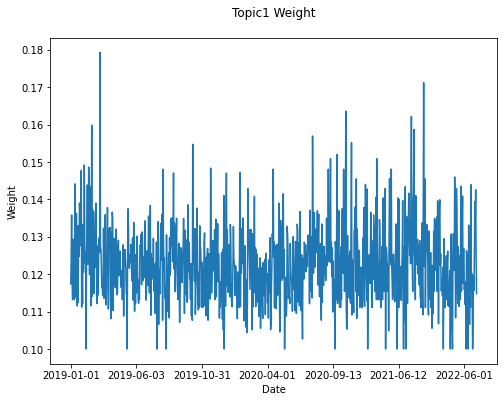

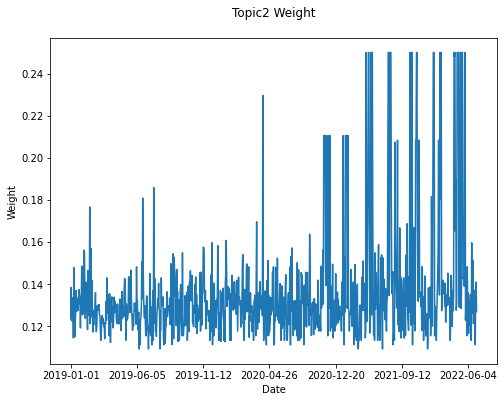

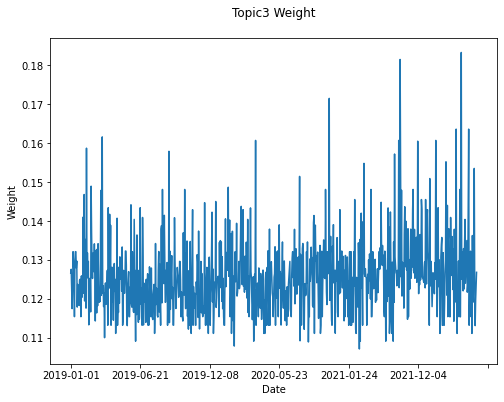

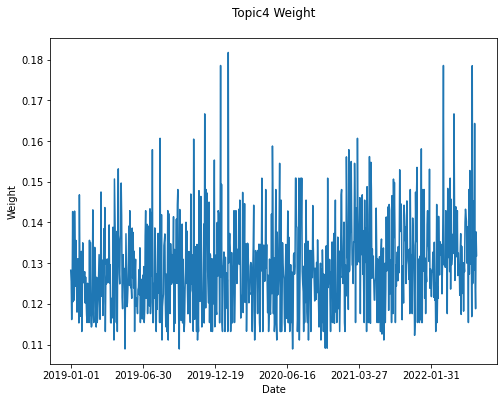

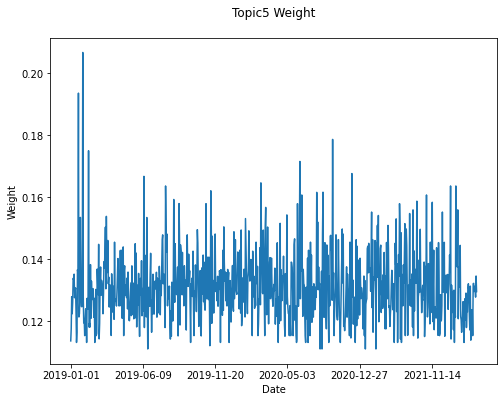

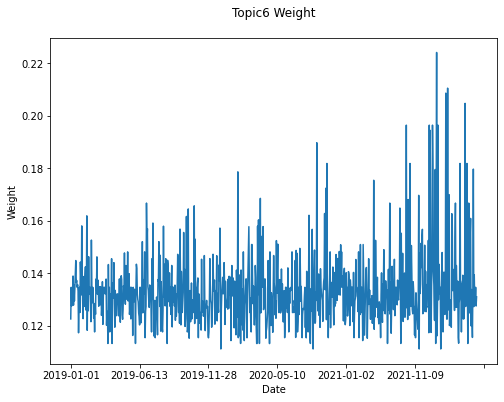

In [ ]:
# 그래프를 그려 트렌드를 살펴보기
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

for i in range(1,7):
    fig = plt.figure(figsize=(8,6))
    plt.plot(globals()['topic_{}_weight'.format(i)])
    plt.title('Topic{} Weight\n'.format(i))
    plt.xlabel('Date')
    plt.ylabel('Weight')
    ax=plt.axes()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.show()

# 6. 딥러닝 주가 예측모델 구현하기

### 6-1. 기존 주가 데이터 불러오기(KODEX 이차전지종목)


In [ ]:
stockdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Selenium/제출용 폴더/Kodex_2ndBattery_20180912_20220719(결측치 채움).csv', encoding='utf-8-sig')
stockdf = stockdf[['일자','종가','시가','고가','저가']]
stockdf.set_index('일자',inplace=True)
stockdf = stockdf.loc['2019-01-01':]
stockdf

,종가,시가,고가,저가
일자,,,,
2019-01-01,8650.0,8715.0,8760.0,8570.0
2019-01-02,8340.0,8725.0,8755.0,8310.0
2019-01-03,8140.0,8345.0,8375.0,8130.0
2019-01-04,8180.0,8080.0,8180.0,7985.0
2019-01-05,8180.0,8080.0,8180.0,7985.0
...,...,...,...,...
2022-07-13,17155.0,16675.0,17165.0,16515.0
2022-07-14,17445.0,17445.0,17700.0,17340.0
2022-07-15,17350.0,17470.0,17530.0,17165.0


In [ ]:
stockdf.info()      # 결측치 없음 확인

<class 'pandas.core.frame.DataFrame'>
Index: 1294 entries, 2019-01-01 to 2022-07-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      1294 non-null   float64
 1   시가      1294 non-null   float64
 2   고가      1294 non-null   float64
 3   저가      1294 non-null   float64
dtypes: float64(4)
memory usage: 50.5+ KB


### 6-2. 주가데이터와 토픽별 트렌드 비중 결합한 새로운 데이터셋 만들기

In [ ]:
stockdf_weight = pd.concat([stockdf, topic_1_weight, topic_2_weight, topic_3_weight, topic_4_weight, topic_5_weight, topic_6_weight], axis=1, join='outer')
stockdf_weight.columns = ['종가','시가','고가','저가','토픽1','토픽2','토픽3','토픽4','토픽5','토픽6']
stockdf_weight.head()

,종가,시가,고가,저가,토픽1,토픽2,토픽3,토픽4,토픽5,토픽6
일자,,,,,,,,,,
2019-01-01,8650.0,8715.0,8760.0,8570.0,0.1174,0.1234,0.1266,0.1283,0.1137,0.1225
2019-01-02,8340.0,8725.0,8755.0,8310.0,0.1238,0.1383,0.1276,0.1255,0.1176,NaN
2019-01-03,8140.0,8345.0,8375.0,8130.0,0.1358,0.1225,NaN,0.1161,0.1279,0.1346
2019-01-04,8180.0,8080.0,8180.0,7985.0,0.1199,0.1245,0.1229,0.1240,0.1224,0.1275
2019-01-05,8180.0,8080.0,8180.0,7985.0,0.1132,0.1334,0.1175,0.1427,0.1260,0.1309


In [ ]:
# .fillna(method='ffill'): 결측치를 전날 값으로 대체한 경우
version_1 = stockdf_weight.fillna(method='ffill')
version_1

,종가,시가,고가,저가,토픽1,토픽2,토픽3,토픽4,토픽5,토픽6
일자,,,,,,,,,,
2019-01-01,8650.0,8715.0,8760.0,8570.0,0.1174,0.1234,0.1266,0.1283,0.1137,0.1225
2019-01-02,8340.0,8725.0,8755.0,8310.0,0.1238,0.1383,0.1276,0.1255,0.1176,0.1225
2019-01-03,8140.0,8345.0,8375.0,8130.0,0.1358,0.1225,0.1276,0.1161,0.1279,0.1346
2019-01-04,8180.0,8080.0,8180.0,7985.0,0.1199,0.1245,0.1229,0.1240,0.1224,0.1275
2019-01-05,8180.0,8080.0,8180.0,7985.0,0.1132,0.1334,0.1175,0.1427,0.1260,0.1309
...,...,...,...,...,...,...,...,...,...,...
2022-07-13,17155.0,16675.0,17165.0,16515.0,0.1426,0.1370,0.1131,0.1643,0.1296,0.1298
2022-07-14,17445.0,17445.0,17700.0,17340.0,0.1426,0.1111,0.1131,0.1250,0.1296,0.1346
2022-07-15,17350.0,17470.0,17530.0,17165.0,0.1426,0.1364,0.1197,0.1188,0.1296,0.1346


In [ ]:
version_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1294 entries, 2019-01-01 to 2022-07-17
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      1294 non-null   float64
 1   시가      1294 non-null   float64
 2   고가      1294 non-null   float64
 3   저가      1294 non-null   float64
 4   토픽1     1294 non-null   float64
 5   토픽2     1294 non-null   float64
 6   토픽3     1294 non-null   float64
 7   토픽4     1294 non-null   float64
 8   토픽5     1294 non-null   float64
 9   토픽6     1294 non-null   float64
dtypes: float64(10)
memory usage: 111.2+ KB


# 7. 기존 LSTM 모델 구현하기

### 7-1. 데이터 전처리

In [174]:
stockprice = stockdf      # 토픽 가중치 추가 없음

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

stockprice.reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가','고가','저가','종가']
stockprice_scaled = scaler.fit_transform(stockprice[scale_cols])
stockprice_scaled = pd.DataFrame(stockprice_scaled)
stockprice_scaled.columns = scale_cols

stockprice_scaled

,시가,고가,저가,종가
0,0.1840,0.1648,0.1920,0.1901
1,0.1846,0.1646,0.1785,0.1743
2,0.1649,0.1446,0.1692,0.1642
3,0.1513,0.1344,0.1618,0.1662
4,0.1513,0.1344,0.1618,0.1662
...,...,...,...,...
1289,0.5950,0.6060,0.6019,0.6224
1290,0.6347,0.6341,0.6445,0.6371
1291,0.6360,0.6252,0.6354,0.6323
1292,0.6360,0.6252,0.6354,0.6323


In [176]:
stockprice_scaled.set_index(stockprice.index, inplace=True)
stockprice_scaled

,시가,고가,저가,종가
일자,,,,
2019-01-01,0.1840,0.1648,0.1920,0.1901
2019-01-02,0.1846,0.1646,0.1785,0.1743
2019-01-03,0.1649,0.1446,0.1692,0.1642
2019-01-04,0.1513,0.1344,0.1618,0.1662
2019-01-05,0.1513,0.1344,0.1618,0.1662
...,...,...,...,...
2022-07-13,0.5950,0.6060,0.6019,0.6224
2022-07-14,0.6347,0.6341,0.6445,0.6371
2022-07-15,0.6360,0.6252,0.6354,0.6323


In [177]:
TEST_SIZE = 30
WINDOW_SIZE = 20        # 과거 20일을 기반으로 내일 데이터를 예측함

train = stockprice_scaled[:-TEST_SIZE]
test = stockprice_scaled[-TEST_SIZE:]

In [178]:
def make_dataset(data, label, window_size=20):      # feature_list와 label_list로 분리 작업
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [179]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가', '고가', '저가']             # 입력 데이터
label_cols = ['종가']                               # 정답 데이터 라벨링

train_feature = train[feature_cols]
train_label = train[label_cols]

# 데이터프레임->넘파이배열
train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((995, 20, 3), (249, 20, 3))

In [180]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((30, 3), (30, 1))

In [181]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((10, 20, 3), (10, 1))

### 7-2. 기존 LSTM 모델 학습단계

In [182]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
         )

model.add(Dense(1))

In [183]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
61/63 [============================>.] - ETA: 0s - loss: 0.1423
Epoch 1: val_loss improved from inf to 0.00894, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 4s 25ms/step - loss: 0.1399 - val_loss: 0.0089
Epoch 2/200
60/63 [===========================>..] - ETA: 0s - loss: 0.0045
Epoch 2: val_loss improved from 0.00894 to 0.00320, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 1s 14ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.0032
Epoch 3: val_loss improved from 0.00320 to 0.00241, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/200
61/63 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00241 to 0.00187, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 1s 15ms/step - loss: 0.0023

### 7-3. 기존 LSTM 모델로 예측한 주가

In [184]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(10, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


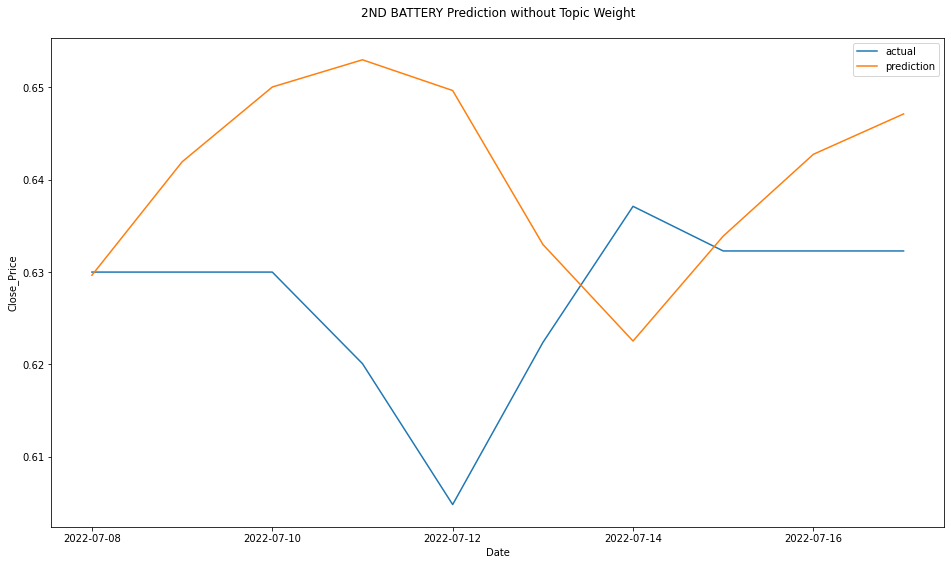

In [185]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

plt.figure(figsize=(16, 9))

index = stockprice_scaled.index[-pred.shape[0]:]

plt.plot(index, test_label, label = 'actual')
plt.plot(index, pred, label = 'prediction')

plt.title('2ND BATTERY Prediction without Topic Weight\n')
plt.xlabel('Date')
plt.ylabel('Close_Price')
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.legend()
plt.show()

# 8. LSTM 모델 구현하기(결측치를 전날 값으로 채운 경우)

### 8-1. 데이터 전처리

In [186]:
stockprice = version_1      # 토픽 가중치 추가 & 결측치 전날 값으로 채움

In [187]:
from sklearn.preprocessing import MinMaxScaler

stockprice.reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['종가','시가','고가','저가','토픽1','토픽2','토픽3','토픽4','토픽5','토픽6']
stockprice_scaled = scaler.fit_transform(stockprice[scale_cols])
stockprice_scaled = pd.DataFrame(stockprice_scaled)
stockprice_scaled.columns = scale_cols

stockprice_scaled

,종가,시가,고가,저가,토픽1,토픽2,토픽3,토픽4,토픽5,토픽6
0,0.1901,0.1840,0.1648,0.1920,0.2194,0.1017,0.2561,0.2654,0.0272,0.1013
1,0.1743,0.1846,0.1646,0.1785,0.3003,0.2075,0.2688,0.2284,0.0681,0.1013
2,0.1642,0.1649,0.1446,0.1692,0.4517,0.0947,0.2688,0.0992,0.1763,0.2080
3,0.1662,0.1513,0.1344,0.1618,0.2506,0.1091,0.2076,0.2068,0.1187,0.1449
4,0.1662,0.1513,0.1344,0.1618,0.1665,0.1722,0.1360,0.4635,0.1565,0.1749
...,...,...,...,...,...,...,...,...,...,...
1289,0.6224,0.5950,0.6060,0.6019,0.5372,0.1979,0.0787,0.7606,0.1937,0.1655
1290,0.6371,0.6347,0.6341,0.6445,0.5372,0.0142,0.0787,0.2209,0.1937,0.2080
1291,0.6323,0.6360,0.6252,0.6354,0.5372,0.1938,0.1654,0.1358,0.1937,0.2080
1292,0.6323,0.6360,0.6252,0.6354,0.3039,0.2257,0.2152,0.3948,0.1937,0.1448


In [188]:
stockprice_scaled.set_index(stockprice.index, inplace=True)
stockprice_scaled

,종가,시가,고가,저가,토픽1,토픽2,토픽3,토픽4,토픽5,토픽6
일자,,,,,,,,,,
2019-01-01,0.1901,0.1840,0.1648,0.1920,0.2194,0.1017,0.2561,0.2654,0.0272,0.1013
2019-01-02,0.1743,0.1846,0.1646,0.1785,0.3003,0.2075,0.2688,0.2284,0.0681,0.1013
2019-01-03,0.1642,0.1649,0.1446,0.1692,0.4517,0.0947,0.2688,0.0992,0.1763,0.2080
2019-01-04,0.1662,0.1513,0.1344,0.1618,0.2506,0.1091,0.2076,0.2068,0.1187,0.1449
2019-01-05,0.1662,0.1513,0.1344,0.1618,0.1665,0.1722,0.1360,0.4635,0.1565,0.1749
...,...,...,...,...,...,...,...,...,...,...
2022-07-13,0.6224,0.5950,0.6060,0.6019,0.5372,0.1979,0.0787,0.7606,0.1937,0.1655
2022-07-14,0.6371,0.6347,0.6341,0.6445,0.5372,0.0142,0.0787,0.2209,0.1937,0.2080
2022-07-15,0.6323,0.6360,0.6252,0.6354,0.5372,0.1938,0.1654,0.1358,0.1937,0.2080


In [189]:
TEST_SIZE = 30
WINDOW_SIZE = 20        # 과거 20일을 기반으로 내일 데이터를 예측함

train = stockprice_scaled[:-TEST_SIZE]
test = stockprice_scaled[-TEST_SIZE:]

In [190]:
def make_dataset(data, label, window_size=20):      # feature_list와 label_list로 분리 작업
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [191]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가','고가','저가','토픽1','토픽2','토픽3','토픽4','토픽5','토픽6']   # 입력 데이터
label_cols = ['종가']                                                                   # 정답 데이터 라벨링

train_feature = train[feature_cols]
train_label = train[label_cols]

# 데이터프레임->넘파이배열
train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((995, 20, 9), (249, 20, 9))

In [192]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((30, 9), (30, 1))

In [193]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((10, 20, 9), (10, 1))

### 8-2. 일별 토픽 가중치를 추가한 LSTM 모델 학습단계

In [194]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
         )

model.add(Dense(1))

In [195]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
59/63 [===========================>..] - ETA: 0s - loss: 0.1529
Epoch 1: val_loss improved from inf to 0.01476, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 2s 11ms/step - loss: 0.1455 - val_loss: 0.0148
Epoch 2/200
58/63 [==========================>...] - ETA: 0s - loss: 0.0085
Epoch 2: val_loss improved from 0.01476 to 0.01002, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0100
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss improved from 0.01002 to 0.00775, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 1s 8ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 4/200
63/63 [==============================] - ETA: 0s - loss: 0.0041
Epoch 4: val_loss improved from 0.00775 to 0.00544, saving model to model/tmp_checkpoint.h5
63/63 [==============================] - 1s 8ms/step - loss: 0.0041 - 

### 8-3. 일별 토픽 가중치를 추가한 LSTM 모델로 예측한 주가

In [196]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(10, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


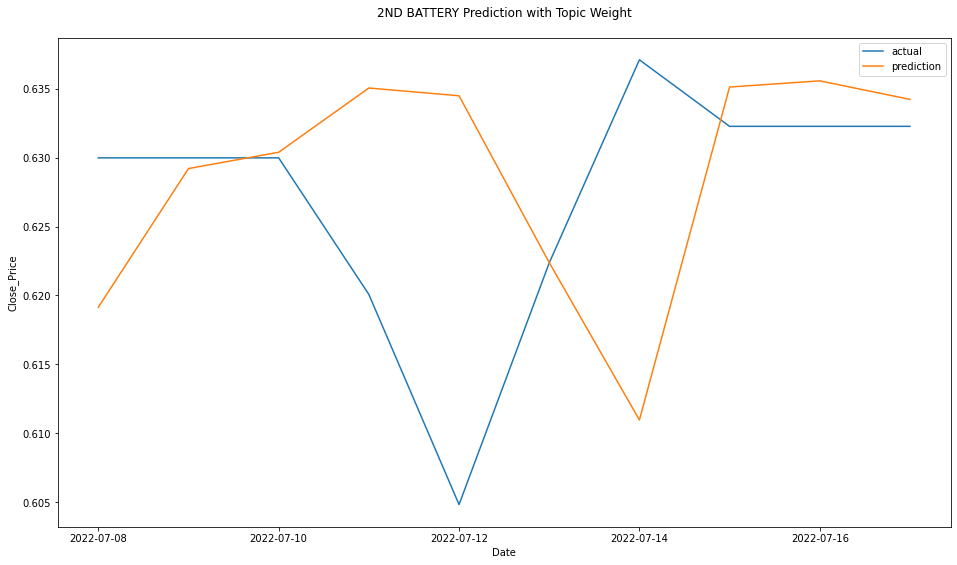

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

plt.figure(figsize=(16, 9))

index = stockprice_scaled.index[-pred.shape[0]:]

plt.plot(index, test_label, label = 'actual')
plt.plot(index, pred, label = 'prediction')
plt.title('2ND BATTERY Prediction with Topic Weight\n')
plt.xlabel('Date')
plt.ylabel('Close_Price')
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.legend()
plt.show()